In [5]:
# if you need any other modules feel free to add them here
import sys
sys.path.append("..") 

from load_data import load_mnist_data
from my_dataset import MyDataset

import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import os

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def train_model(model, criterion, optimizer, trainloader, epochs=10, devloader=None, print_info=True):
    epochs_loss = []
    epoch_acc = []
    running_loss = 0.0
    # the length of the train loader will give you the number of mini-batches
    # not the cleanest solution but for now it generalizes well and avoids 
    # computation that we don't need
    minibatches = len(trainloader)
    # moving the network onto the gpu/cpu
    model = model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0.0
#         batches_complete = 0
        for batch, labels in trainloader: # Per this doc, (batch,labels) = trainloader.__getitem__(); https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

            # Keeping track of number of batches processed
#             if batches_complete % 1000 == 0:
#                 print("BATCHES COMPLETE: ", batches_complete)
#             batches_complete += 1
            
            # batch is a tensor with m elements, where each element is 
            # a training example

            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)
            
            # zeroing the parameters of the model 
            # becuase we want to optimize them
            optimizer.zero_grad()
            
            # forward pass
            # getting the predictions from our model by passing in a mini-batch
            # the ouput will have shape (mini-batch-size, number-of-classes)
            # where each element of output is the probabliity of that example being
            # the classification correspoding to the index of the value
            output = model(batch.float()) # <---- Added .float() as a modification to avoid Runtime error per this post: https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
            loss = criterion(output, labels.long()) # <---- Added .long() per a CampusWire discussion in post #2505
            
            # backward pass
            loss.backward()
            
            # optimize the parameters
            optimizer.step()
            
            # add the loss of a mini-batch to the list of epoch loss
            epoch_loss += loss.item()

        #  after each epoch we need to average out the loss across all minibatches
        epochs_loss.append(epoch_loss/minibatches)
        # printing some info
        if print_info:
            print(f'Epoch: {epoch} Loss: {epoch_loss/minibatches}')
    return model, epoch_loss
                

def test_model(model, testloader): # Takes in just model you want to test and the data you want to test it on
    # variables to keep count of correct labels and the total labels in a mini batch
    correct = 0
    total = 0
    model.to(device) # <---- Added this to try and avoid runtime error
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
        for batch, labels in testloader:
            batch, labels = batch, labels # So we don't modify original dataset?
            batch = batch.to(device) # <---- Added this end line below to fix error when runinng on GPU
            labels = labels.to(device)
            output = model(batch.float()) # <---- Added .float() to solve for RuntimeError
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy
    
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cuda


In [7]:
# Checking the type of GPU
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [8]:
train_datasets = dict()

for size in [500,1000,1500, 2000]:
    example_data_split = load_mnist_data(10, 1.0, size/10)
    example_training_set = MyDataset(example_data_split[0], example_data_split[2])
    train_datasets[size] = example_training_set

In [9]:
# Let's double-check that all our training datasets are balanced
for key, value in train_datasets.items():
    print(np.unique(value.y, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200]))


In [10]:
train_loaders = dict()

for key, value in train_datasets.items():
    
    train_loaders[key] = torch.utils.data.DataLoader(value,
                                                     batch_size=4,
                                                     shuffle=True,
                                                     num_workers=2)

In [11]:
# I created the training sets above; below I create the testing dataset per the instructions originally in this notebook
# testing set
data_split = load_mnist_data(10, 0, 100) # I'm a bit confused as to why we call load_mnist_data twice; 
                                          # it is capable of giving us train & test data at the same time; 
                                          # aren't we duplicating observations across train and test set this way?
                                          # Maybe it's to ensure we all have the same test dataset :shrug
testing_set = MyDataset(data_split[1], data_split[3])

# And then the test DataLoader
test_loader = torch.utils.data.DataLoader(testing_set
                                          , batch_size=4
                                          , shuffle=False # I think for the test dataset I don't need shuffle=True
                                          , num_workers=2) 

In [12]:
np.unique(data_split[3], return_counts=True) # We get 100 samples each when taking size 100;;;When using size=1000, We don't have the full 1000 observations for each class

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

In [13]:
class mnistNet(nn.Module):
    def __init__(self):
        super(mnistNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.log_softmax(x, dim=1) # According to the documentation, I don't need to add log_softmax, because it is integrated in the CrossEntropyLoss class
        return x

In [14]:
# Dicionaries to track metrics
# training time
training_time = {}
# training loss
training_loss = {}
# training accurary 
training_acc = {}
# testing loss 
# OPTIONAL
testing_loss = {}
# testing acc
testing_acc = {}


In [15]:
for size, train_loader in train_loaders.items():
    
    start = time.time()

    mnist_net = mnistNet()
    mnist_net = mnist_net.float()
    mnist_net.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    solver = optim.SGD(params=mnist_net.parameters() ,lr=0.01)

    trained_model, epochs_loss = train_model(model=mnist_net
                                             , criterion = loss_function
                                             , optimizer = solver
                                             , trainloader = train_loader
                                             , epochs = 100
                                             , print_info=True)
    
    end = time.time()
    
    test_accuracy = test_model(trained_model, test_loader) 
    
    training_time[size] = end-start
    training_loss[size] = epochs_loss
    testing_acc[size] = test_accuracy

Epoch: 0 Loss: 2.296182439804077
Epoch: 1 Loss: 2.2526584796905516
Epoch: 2 Loss: 2.1713532848358152
Epoch: 3 Loss: 2.012085599899292
Epoch: 4 Loss: 1.7428592472076416
Epoch: 5 Loss: 1.385865303516388
Epoch: 6 Loss: 1.060502081155777
Epoch: 7 Loss: 0.8432903773784638
Epoch: 8 Loss: 0.689264006614685
Epoch: 9 Loss: 0.5809567043185234
Epoch: 10 Loss: 0.4951387250125408
Epoch: 11 Loss: 0.42987738192081454
Epoch: 12 Loss: 0.3797242538332939
Epoch: 13 Loss: 0.32927333608269693
Epoch: 14 Loss: 0.2867784509211779
Epoch: 15 Loss: 0.25854796512424943
Epoch: 16 Loss: 0.22701621165499092
Epoch: 17 Loss: 0.2004079978018999
Epoch: 18 Loss: 0.17485644686967133
Epoch: 19 Loss: 0.15214270916581155
Epoch: 20 Loss: 0.13765898482501507
Epoch: 21 Loss: 0.12200029925443232
Epoch: 22 Loss: 0.105477826975286
Epoch: 23 Loss: 0.09453698626533151
Epoch: 24 Loss: 0.0848184593487531
Epoch: 25 Loss: 0.07718228360265493
Epoch: 26 Loss: 0.07032095680106432
Epoch: 27 Loss: 0.06323556123673915
Epoch: 28 Loss: 0.056478

In [19]:
training_time

{500: 54.05074453353882,
 1000: 102.80809140205383,
 1500: 150.7574336528778,
 2000: 201.75717663764954}

These are the training sizes and training times on Colab with this type of GPU:
name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB

{500: 46.94939208030701,
 1000: 82.18376970291138,
 1500: 118.70786213874817,
 2000: 152.77479720115662}


 I also tried the same on a TPU and actually got slower training time!

 {500: 54.05074453353882,
 1000: 102.80809140205383,
 1500: 150.7574336528778,
 2000: 201.75717663764954}


 The testing accuracies on TPU are:
 {500: 83.0, 1000: 84.4, 1500: 86.6, 2000: 88.4}





In [27]:
gpu={500: 46.94939208030701, 1000: 82.18376970291138, 1500: 118.70786213874817, 2000: 152.77479720115662}

In [18]:
from matplotlib import style
style.use('fivethirtyeight')

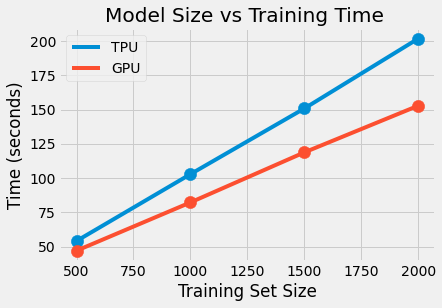

In [30]:
plt.plot(list(training_time.keys()), list(training_time.values()), label='TPU')
plt.scatter(list(training_time.keys()), list(training_time.values()), s=150)
plt.plot(list(gpu.keys()), list(gpu.values()), label='GPU')
plt.scatter(list(gpu.keys()), list(gpu.values()), s=150)
plt.title("Model Size vs Training Time ")
plt.xlabel('Training Set Size')
plt.ylabel('Time (seconds)')
plt.legend()

In [33]:
tpu_acc = {500: 83.0, 1000: 84.4, 1500: 86.6, 2000: 88.4}

In [35]:
tpu_acc

{500: 83.0, 1000: 84.4, 1500: 86.6, 2000: 88.4}

In [16]:
testing_acc

{500: 82.3, 1000: 83.8, 1500: 87.1, 2000: 88.4}

Text(0, 0.5, 'Accuracy %')

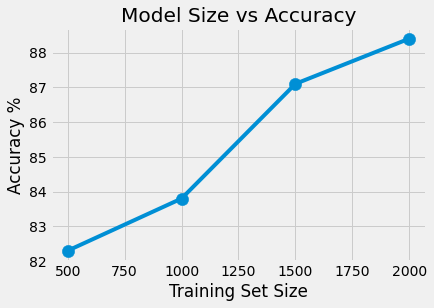

In [20]:
plt.plot(list(testing_acc.keys()), list(testing_acc.values()))
plt.scatter(list(testing_acc.keys()), list(testing_acc.values()), s=150)
plt.title("Model Size vs Accuracy")
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy %')